# Obrada je važna!

<img src="nb_images/800px-Charles_Babbage_-_1860.jpg" width="200" align="right">

## Charles Babbage (1791-1871)



### Britanski naučnik, "otac računara" - koncept računara koji se mogu programirati



### Ulazni podaci su veoma bitni!

<blockquote style="font-size:x-large; font-style: italic;">
On two occasions I have been asked, "Pray, Mr. Babbage, if you put into the machine wrong figures, will the right answers come out?" ... I am not able rightly to apprehend the kind of confusion of ideas that could provoke such a question.
</blockquote>

Da bi se problem rešio potrebno je odgovarajuće nizove podataka **pravilno** interpretirati.

Ne može se od netačnih i nepravilno obrađenih podataka očekivati da (osim slučajno) daju korektno rešenje. 

### Princip poznat i kao GIGO: Garbage In, Garbage Out

![garbage_paradigm](nb_images/garbage_paradigm.gif)

## Kontekst zadatka i njegova postavka

### Cilj: pronaći sumu cifara sa slike

* crna pozadina
* bele cifre 
* šum na slici

### Problem: prepoznati cifre

## Kako se razlikuje od ranijih zadataka?

### Problem: izdvojiti cifre

1. sliding window
2. **izdvajanje povezanih regiona**

### Postavka okruženja

In [1]:
%matplotlib inline

import numpy as np

from sklearn.datasets import fetch_mldata
from skimage.io import imread, show
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops
from sklearn.neighbors import KNeighborsClassifier

from matplotlib.pyplot import imshow as imshow

### Učitavanje i prva obrada MNIST skupa

In [2]:
#ucitavanje MNIST dataseta
mnist = fetch_mldata('MNIST original')

data = mnist.data>0
data = data.astype('uint8')

target = mnist.target

### Primer elementa MNIST skupa

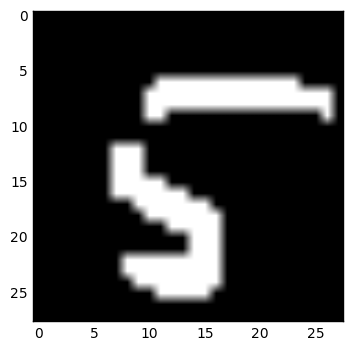

In [3]:
primer = data[30755]
imshow(primer.reshape(28,28),'gray')

## Normalizacija MNIST skupa

In [4]:
#pomeranje slike u gornji levi ugao
def move(image,x,y):
    img = np.zeros((28,28))
    img[:(28-x),:(28-y)] = image[x:,y:]

    return img

### Praktično

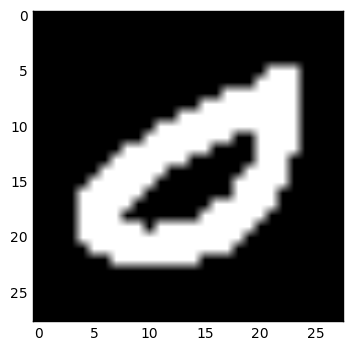

In [5]:
primer_2 = data[1234]
imshow(primer_2.reshape(28,28),'gray')

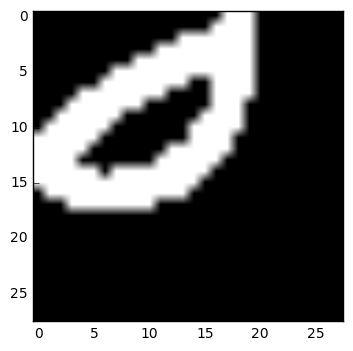

In [6]:
l = label(primer_2.reshape(28,28))
r = regionprops(l)

normalizovana = move(primer_2.reshape(28,28),r[0].bbox[0],r[0].bbox[1])

imshow(normalizovana, 'gray')

### Problem?

In [7]:
l = label(primer.reshape(28,28))
r = regionprops(l)

print(len(r))

2


### O čemu je reč?

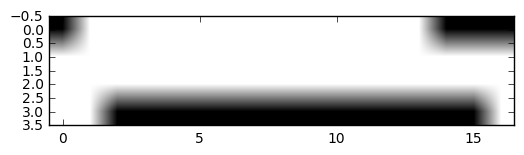

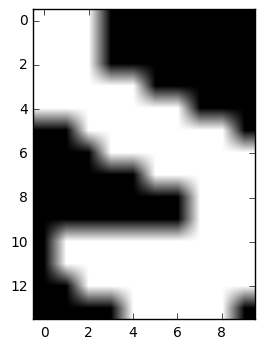

In [8]:
for element in r:
    imshow(element.image,'gray')
    show()

### Rešenje?

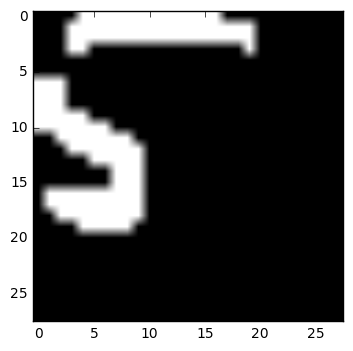

In [9]:
min_x = r[0].bbox[0]
min_y = r[0].bbox[1]

for j in range(1,len(r)):
    if(r[j].bbox[0]<min_x):
        min_x = r[j].bbox[0]
    if(r[j].bbox[1]<min_y):
        min_y = r[j].bbox[1]

img = move(primer.reshape(28,28),min_x,min_y)

imshow(img,'gray')

### Primenjeno na ceo MNIST skup

In [10]:
#obrada podataka za trening
obradjene = np.empty_like(data)

for i in range(0,len(data)):
    l = label(data[i].reshape(28,28))
    r = regionprops(l)

    min_x = r[0].bbox[0]
    min_y = r[0].bbox[1]

    for j in range(1,len(r)):
        if(r[j].bbox[0]<min_x):
            min_x = r[j].bbox[0]
        if(r[j].bbox[1]<min_y):
            min_y = r[j].bbox[1]
                    
    img = move(data[i].reshape(28,28),min_x,min_y)
    obradjene[i]= img.reshape(784,)

### Nekoliko poznatih funkcija

In [11]:
def my_rgb2gray(img_rgb):
    img_gray = np.ndarray((img_rgb.shape[0], img_rgb.shape[1]))
    img_gray = 0.5*img_rgb[:, :, 0] + 0.0*img_rgb[:, :, 1] + 0.5*img_rgb[:, :, 2]
    img_gray = img_gray.astype('uint8')
    return img_gray

def ucitavanje(path):
    image_path = []

    with open(path) as f:
        data = f.read()
        lines = data.split('\n')
        for i, line in enumerate(lines):
            if(i>1):
                cols = line.split('\t')
                if(cols[0]!=''):
                    image_path.append(cols[0])         
        f.close()   
        
    return image_path


#postavljanje i obucavanje KNN
def fitKNN(data,target):
    print('Setting up the classifier.')
    knn = KNeighborsClassifier(n_neighbors=1,weights='uniform',algorithm='auto', n_jobs=-1)
    knn.fit(data,target)
    print('Classifier is set.')
    return knn

### Učitavanje slika, deklaracija promenljivih, obučavanje klasifikatora

In [12]:
knn = fitKNN(obradjene, target)

image_path = []
result = []
    
train_out = 'level-2-mnist-train/level-2-mnist-train/out.txt'
test_out = 'level-2-mnist-test/level-2-mnist-test/out.txt'

train_path = 'level-2-mnist-train/level-2-mnist-train/'
test_path = 'level-2-mnist-test/level-2-mnist-test/'

image_paths = ucitavanje(test_out)

Setting up the classifier.
Classifier is set.


## Inicijalni problem

### Izdvajanje regiona

level-2-mnist-test/level-2-mnist-test/images/img-12.png


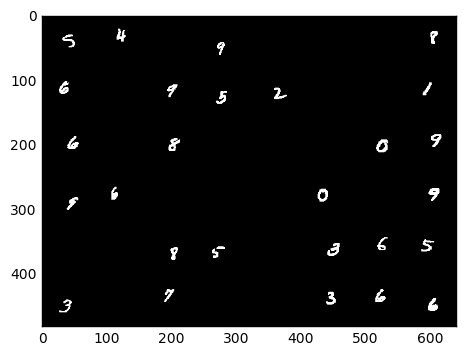

In [13]:
path = test_path+image_paths[12]
print(path)
image = imread(path)
image = my_rgb2gray(image) > 0
image = remove_small_objects(image,min_size=32)
imshow(image,'gray')
show()

### Izdvajanje regiona

In [14]:
regions = label(image)
labels = regionprops(regions)

len(labels)

28

### 27 cifara, 28 regiona?

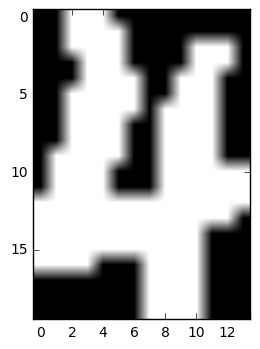

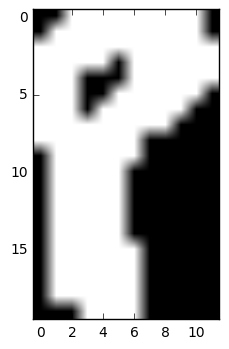

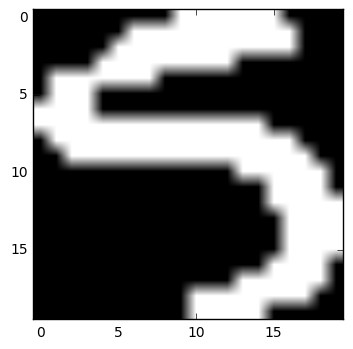

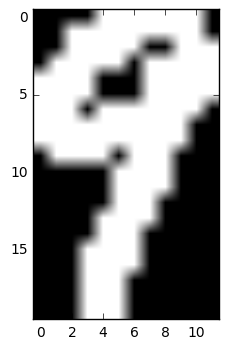

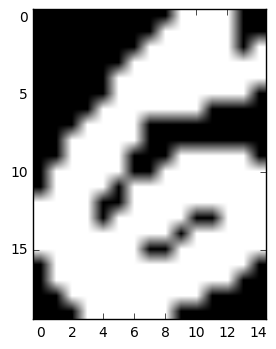

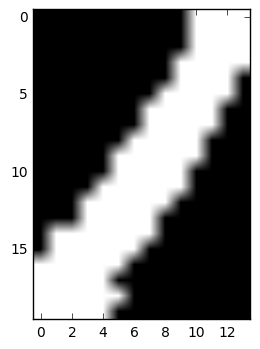

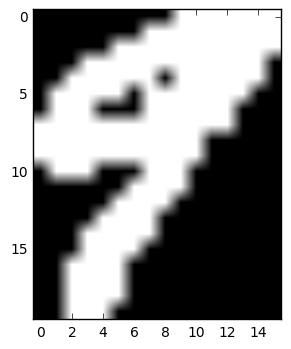

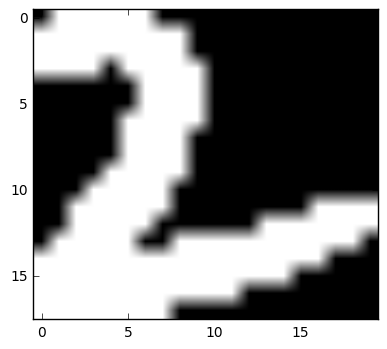

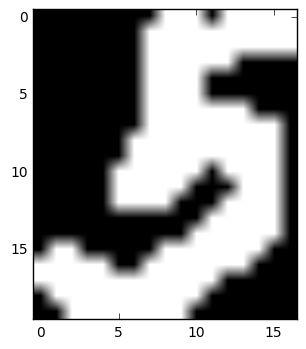

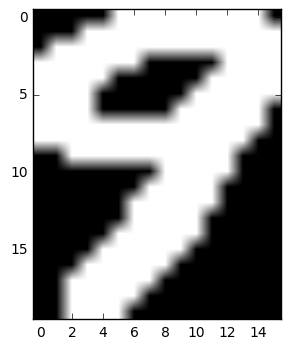

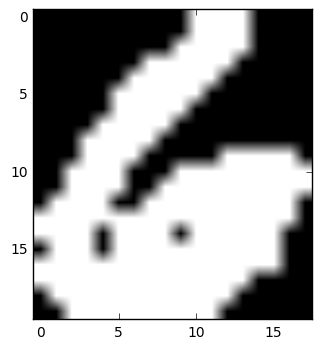

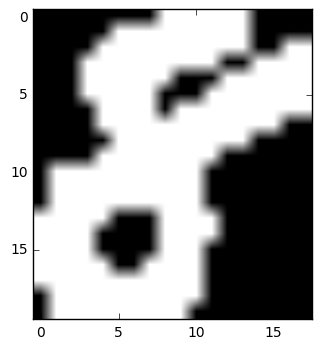

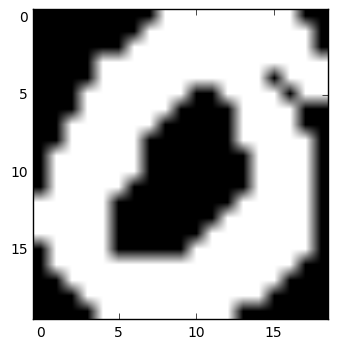

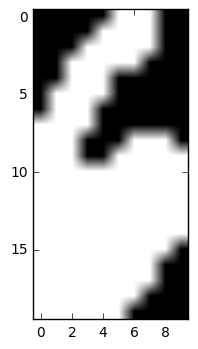

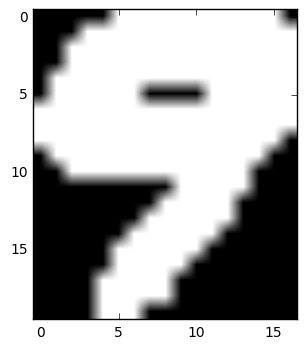

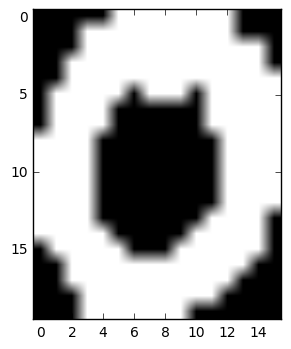

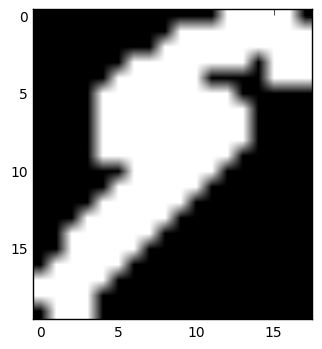

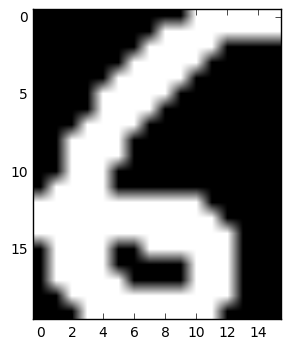

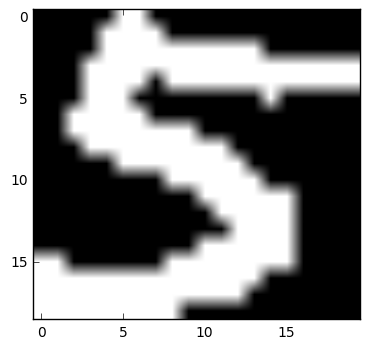

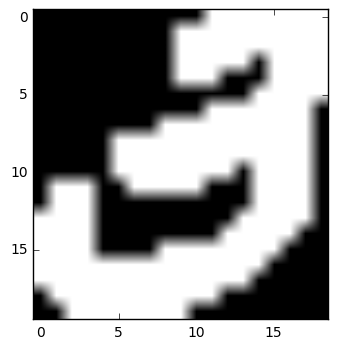

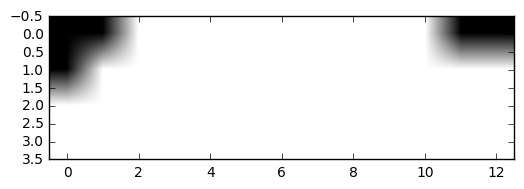

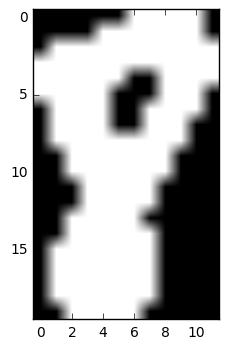

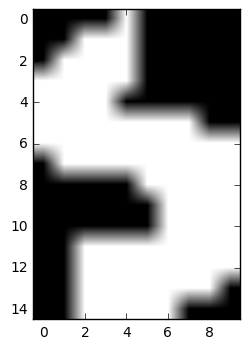

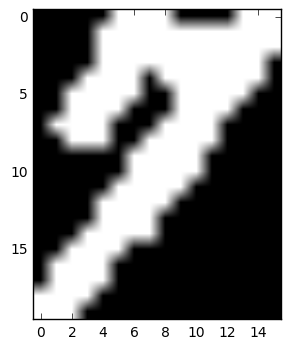

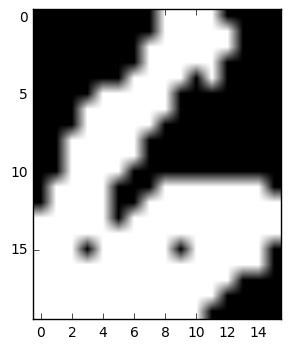

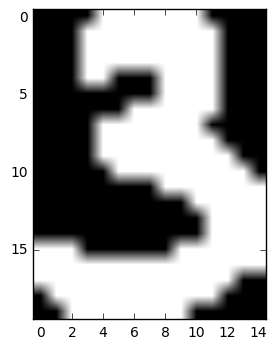

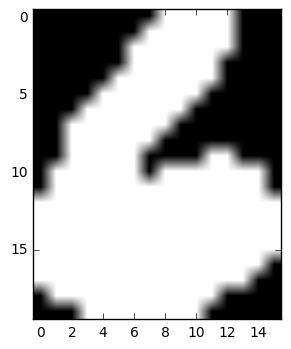

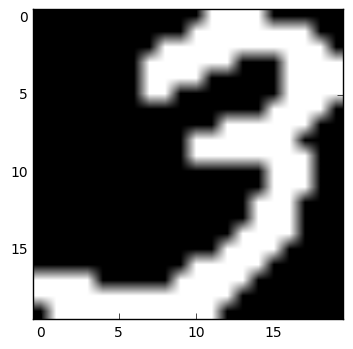

In [15]:
for label in labels:
    imshow(label.image,'gray')
    show()

### Brojevi sa više nespojenih segmenata

In [16]:
#provera da li se regioni preklapaju
def check(c1,c2,par=15):
    if(abs(c1[0]-c2[0])<=par and abs(c1[1]-c2[1])<=par):
        return True
    else:
        return False
    
def check2(indices,i):
    check = False
    for el in indices:
        if(el==i):
            check = True
            break
        
    return check

### Provera nad označenim delovima slike

In [19]:
overlap = False
for i in range(0,len(labels)):
    for j in range(i+1,len(labels)):
        if(check(labels[i].centroid,labels[j].centroid,15)):   #promeniti radijus na 2 kako bi se pokazalo i suprotno
            overlap = True
            print('Neki segmenti se preklapaju!')
            break
            
if(not(overlap)):
    print('Segmenti se ne preklapaju!')

Neki segmenti se preklapaju!


### Spoj dva regiona

In [20]:
#spoj dva bliska regiona
def merge(image,bbox1,bbox2):
    if(bbox1[0]<bbox2[0]):
        x=bbox1[0]
    else:
        x=bbox2[0]

    if(bbox1[1]<bbox2[1]):
        y=bbox1[1]
    else:
        y=bbox2[1]

    return(image[x:x+28,y:y+28])

### Obrada ulaznih podataka

In [21]:
images = []
indices = []

for i in range(0,len(labels)):
    overlap = False
    for j in range(i+1,len(labels)):
        if(check(labels[i].centroid,labels[j].centroid,15)):
            overlap = True
            tmp = merge(image,labels[i].bbox,labels[j].bbox)
            images.append(tmp)
            indices.append(j)
    if(overlap==False and check2(indices,i)==False):
        images.append(labels[i].image)

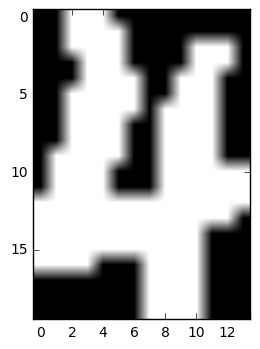

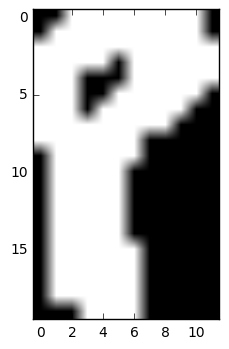

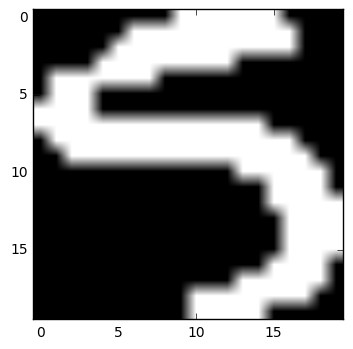

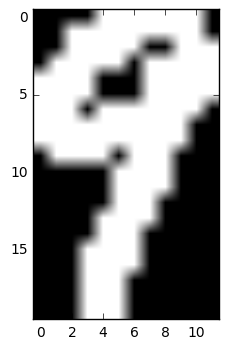

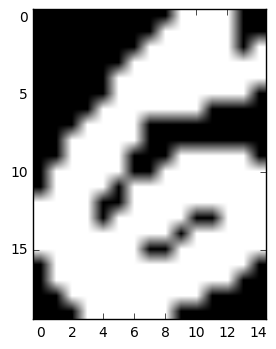

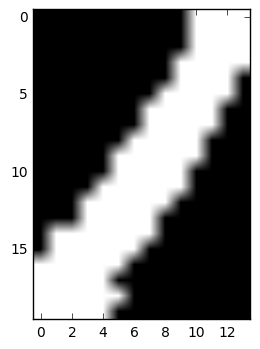

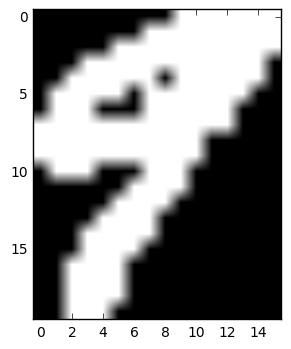

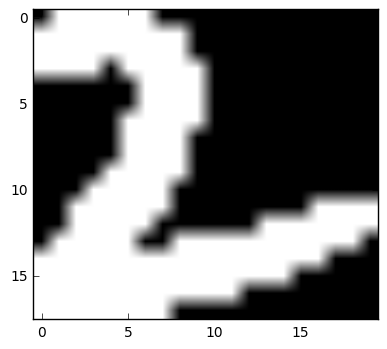

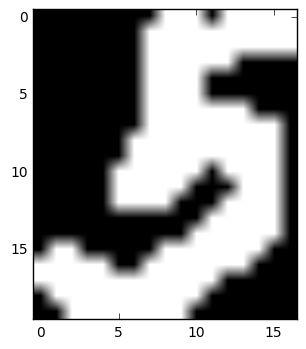

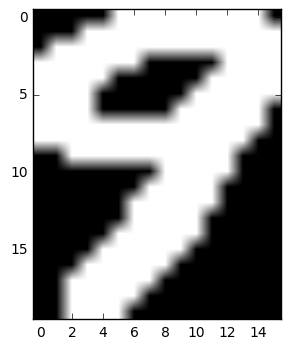

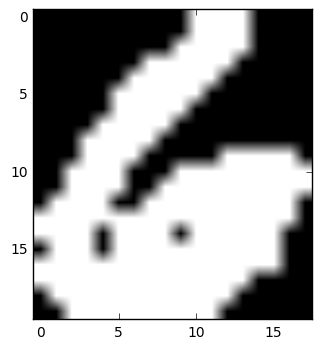

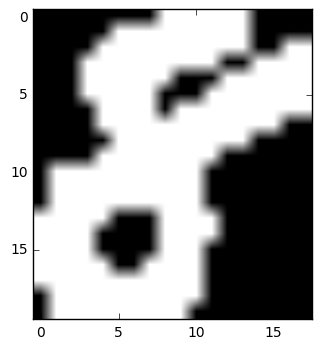

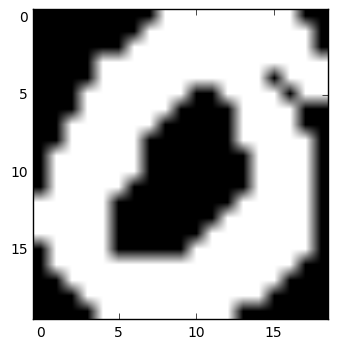

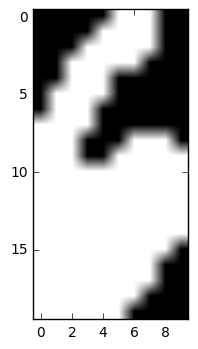

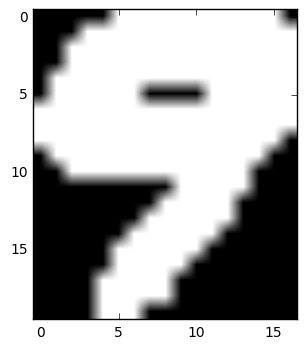

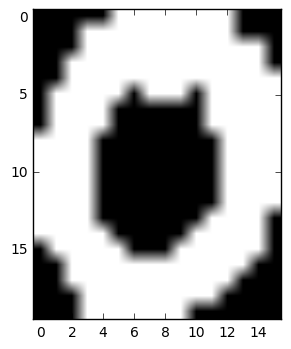

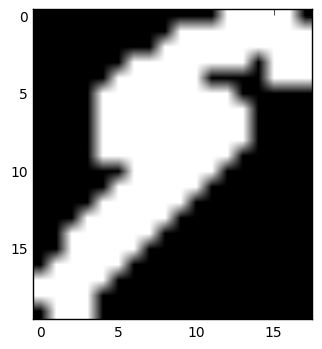

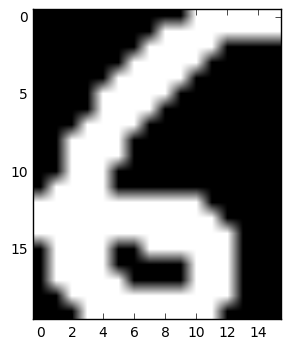

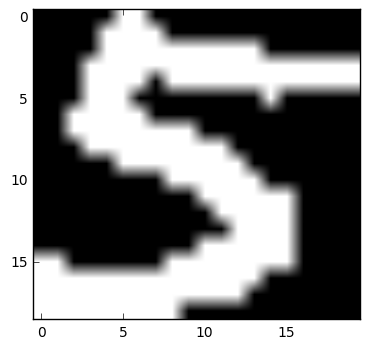

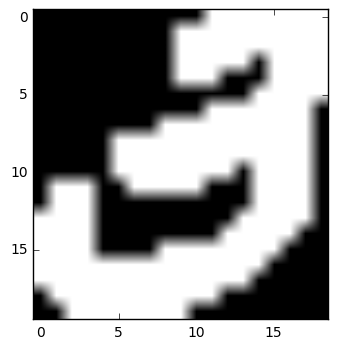

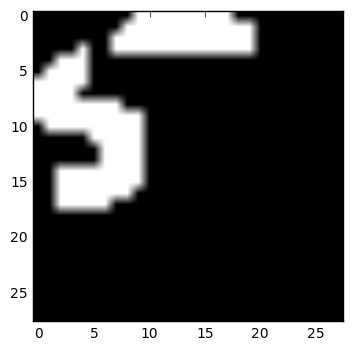

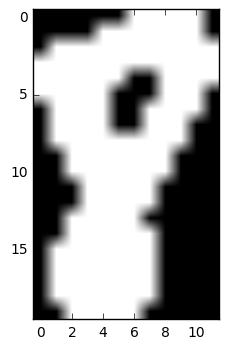

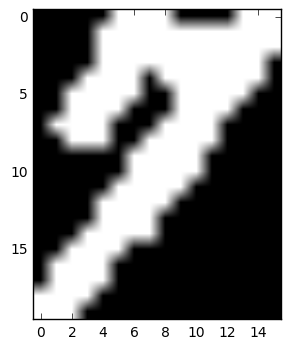

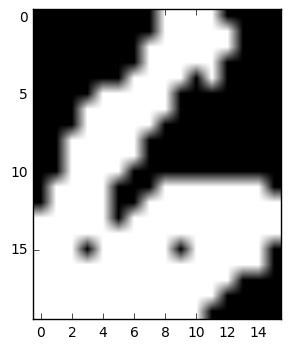

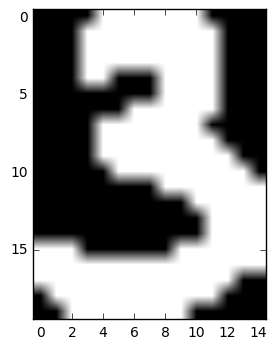

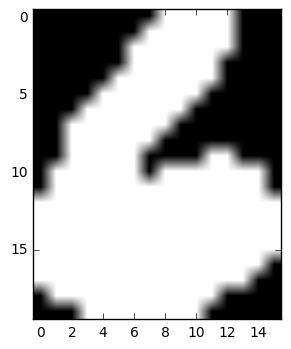

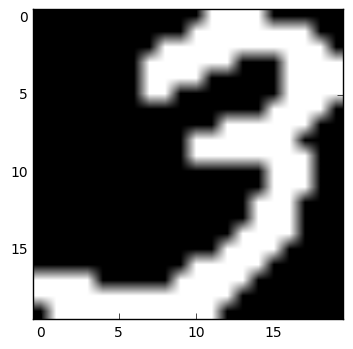

In [22]:
for image in images:
    imshow(image,'gray')
    show()

### Podaci moraju biti uniformni

In [23]:
#dopunjavanje slike do 28x28
def fill(image):
    if(np.shape(image)!=(28,28)):
        img = np.zeros((28,28))
        x = 28 - np.shape(image)[0]
        y = 28 - np.shape(image)[1]
        img[:-x,:-y] = image
        return img
    else:
        return image

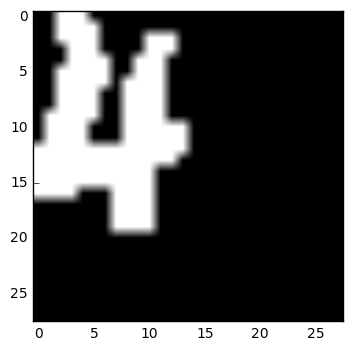

In [24]:
imshow(fill(images[0]),'gray')

## Primena u rešenju problema

[ 4.]


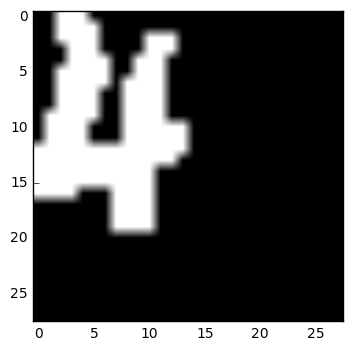

[ 8.]


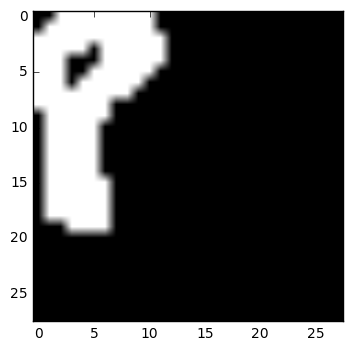

[ 5.]


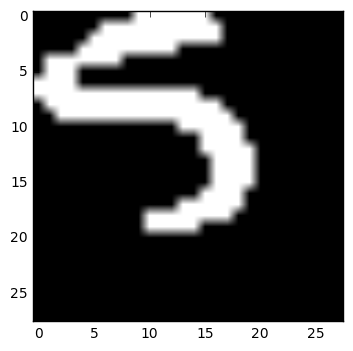

[ 9.]


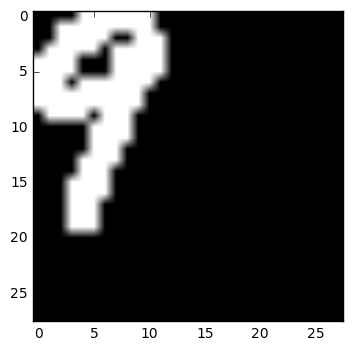

[ 6.]


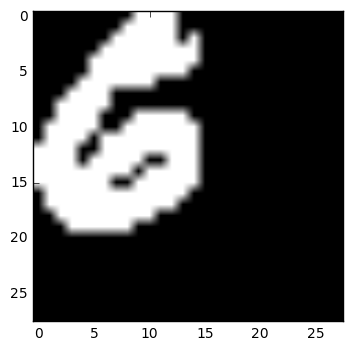

[ 1.]


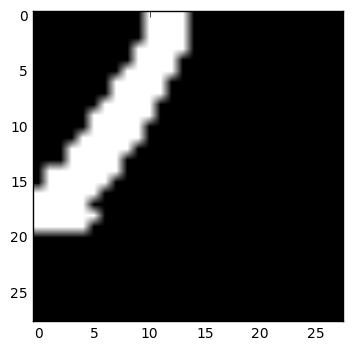

[ 9.]


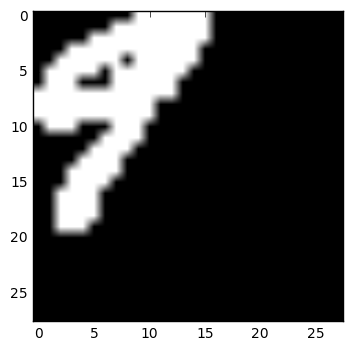

[ 2.]


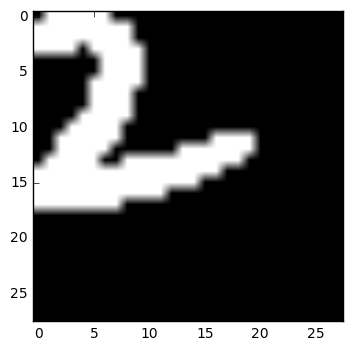

[ 5.]


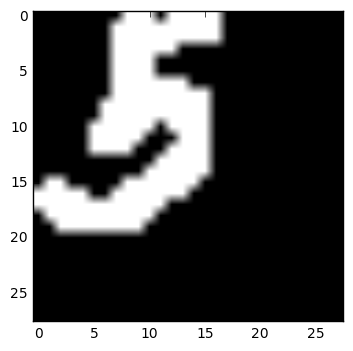

[ 9.]


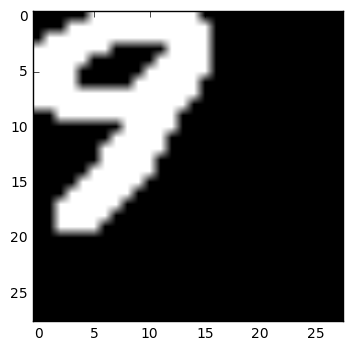

[ 6.]


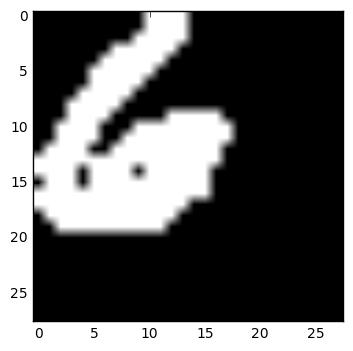

[ 8.]


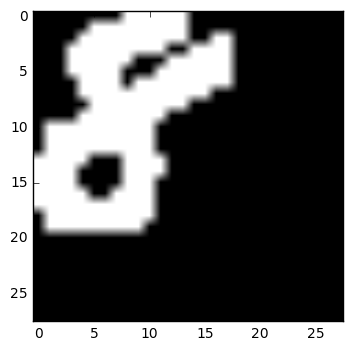

[ 0.]


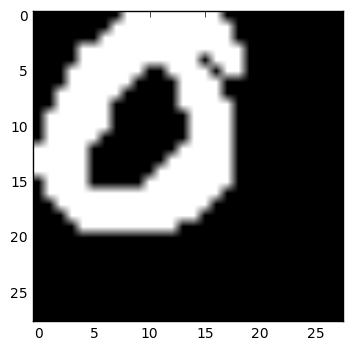

[ 6.]


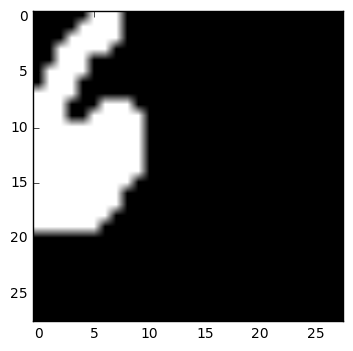

[ 9.]


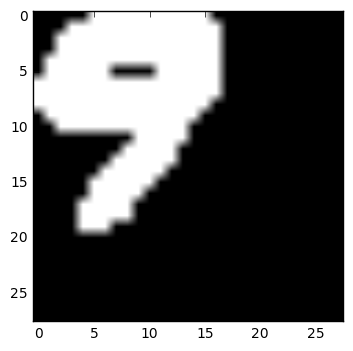

[ 0.]


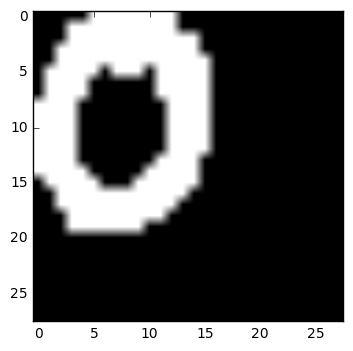

[ 9.]


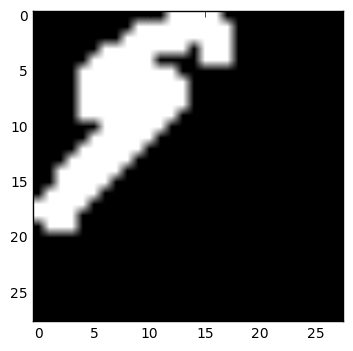

[ 6.]


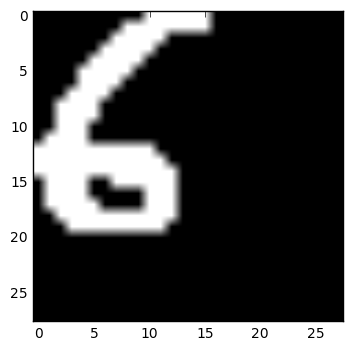

[ 5.]


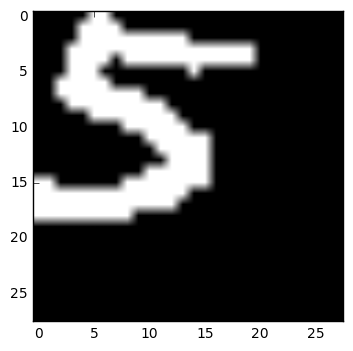

[ 3.]


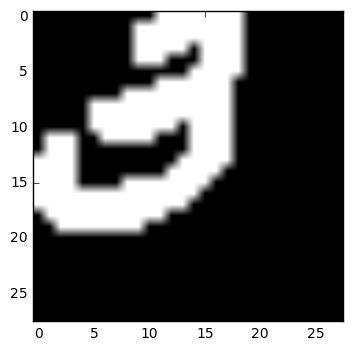

[ 5.]


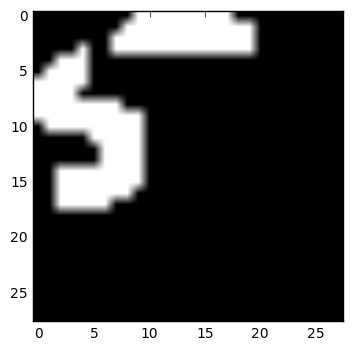

[ 8.]


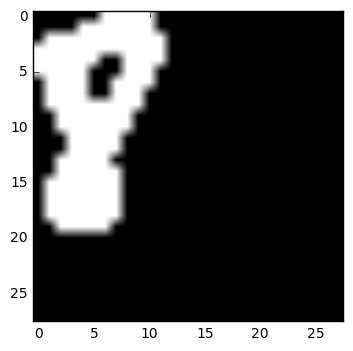

[ 7.]


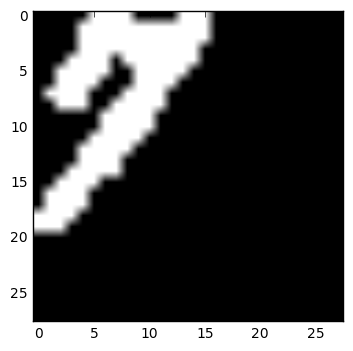

[ 6.]


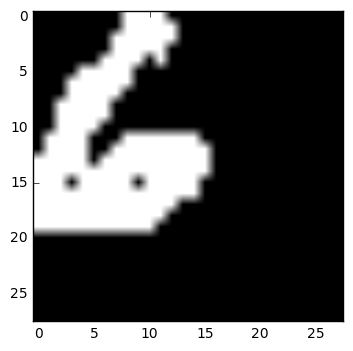

[ 3.]


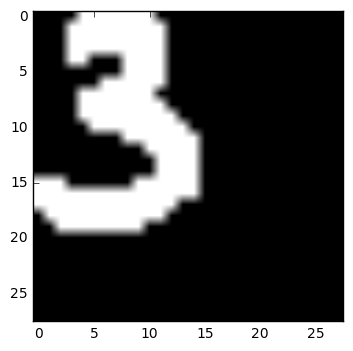

[ 6.]


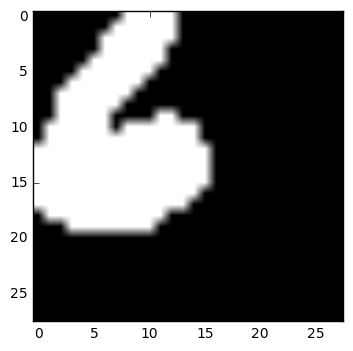

[ 3.]


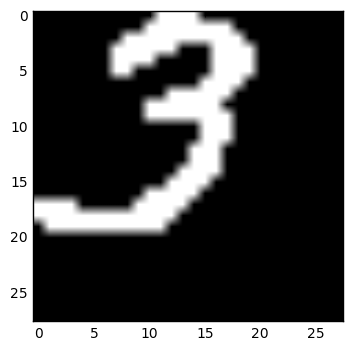

In [25]:
for img in images:
    obrada = fill(np.array(img.astype('uint8')))
    print(knn.predict(obrada.reshape(1,-1)))
    imshow(obrada.astype('uint8'),'gray')
    show()